In [1]:
# Librerias específicas de Tratamiento de imágenes RMI y fRMI
#!{sys.executable} -m pip install antspyx --no-cache-dir

import ants  # instalar con pip install antspyx
import nibabel as nib
from nilearn.plotting import plot_anat, plot_epi
import nilearn.plotting as plotting

from nilearn import datasets
from scipy.ndimage import gaussian_filter


In [2]:
# Librerias de Sistema
import subprocess
import os

# Gestión de imágenes y Gráficos
from PIL import Image  
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Librerías Torch
import torch
from torch.utils.data import Dataset, DataLoader,  random_split

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Librerias de Scikit-Learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)


# Preprocesamiento

In [26]:
# Ruta base del dataset
#base_path = r"V:\\Datasets\\Dallas\\ds004856-1.2.0"
base_path =r'C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0'
def get_nii_paths(base_path, target_dirname):
    nii_paths = []
    
    # Recorremos toda la estructura de subdirectorios
    for root, dirs, files in os.walk(base_path):
        # Verificamos si el nombre final del directorio actual es "dwi"
        if os.path.basename(root) == target_dirname:
            # Buscamos archivos que terminen en .nii o .nii.gz
            for file in files:
                if file.endswith(".nii") or file.endswith(".nii.gz"):
                    full_path = os.path.join(root, file)
                    nii_paths.append(full_path)

    return nii_paths

target_dirname = "anat"
nii_paths =  get_nii_paths(base_path, target_dirname)
#target_dirname = "pet"
#nii_paths_bold =  get_nii_paths(base_path, target_dirname)

print(f"\nTotal de archivos encontrados anat: {len(nii_paths)}")
#print(f"\nTotal de archivos encontrados bold: {len(nii_paths_bold)}")
mni = datasets.load_mni152_template(resolution=1)
mni_path = 'mni_template.nii.gz'
mni_path= nii_paths[500]
mni.to_filename(mni_path)



Total de archivos encontrados anat: 1935


In [27]:
def pipeline_preprocess(rmi_path, mni_path, dir_output='d:\\'):
    rmi = ants.image_read(rmi_path)
    mni = ants.image_read(mni_path)

    # Paso 1: original
    original_np = rmi.numpy()
    mni_np = mni.numpy()
    # Paso 2: registro afín
    tx2 = ants.registration(fixed=mni, moving=rmi, type_of_transform='Affine')
    rmi_reg = tx2['warpedmovout']
    registered_np = rmi_reg.numpy()

    # Paso 3: suavizado
    sigma = 1
    smoothed_np = gaussian_filter(registered_np, sigma=sigma)

    # Paso 4: normalización z-score
    mean = np.mean(smoothed_np)
    std = np.std(smoothed_np)
    normalized_np = (smoothed_np - mean) / std

    # Mostrar los cuatro resultados en un solo plot
    slice_index = original_np.shape[2] // 2  # corte axial central
    images = [mni_np, original_np, registered_np, smoothed_np, normalized_np]
    titles = ['Plantilla MNI', 'RMI Original', 'Registrada (Affine)', f'Suavizada (σ={sigma})', 'Normalizada (Z-score)']

    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[:, :, slice_index], cmap='gray', origin='lower')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


    # Reconversión a imagen ANTs para guardar
    normalized_img = ants.from_numpy(
        normalized_np,
        origin=rmi_reg.origin,
        spacing=rmi_reg.spacing,
        direction=rmi_reg.direction
    )

    # Reconstruir ruta BIDS
    path_parts = rmi_path.split(os.sep)
    try:
        sub_index = next(i for i, part in enumerate(path_parts) if part.startswith('sub-'))
    except StopIteration:
        raise ValueError("No se encontró una carpeta 'sub-*' en la ruta anat_path")

    relative_path = os.path.join(*path_parts[sub_index:])
    
    # Agregar sufijo "_preproc"
    base, ext = os.path.splitext(relative_path)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    output_path = os.path.join(dir_output, base + '_preproc' + ext)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    normalized_img.to_filename(output_path)

    print(f"Guardado en: {output_path}")


In [28]:

def get_axial_center_slice(img):
    """Extrae la slice axial central (en índice) de una imagen ya reorientada y alineada."""
    array = img.numpy()
    z_index = array.shape[2] // 2
    return array[:, :, z_index]

def pipeline_preprocess2(rmi_path, mni_path, dir_output='d:\\', z_mm=0.0, debug = False):
    # Leer imágenes
    rmi = ants.image_read(rmi_path)
    mni = ants.image_read(mni_path)
    print(mni_path)
    # Registro en dos etapas
    tx_rigid = ants.registration(fixed=mni, moving=rmi, type_of_transform='Rigid')
    rigid_img = tx_rigid['warpedmovout']

    tx_affine = ants.registration(fixed=mni, moving=rigid_img, type_of_transform='Affine')
    rmi_reg = tx_affine['warpedmovout']

    # Suavizado
    sigma = 1
    #smoothed_np = gaussian_filter(rmi_reg.numpy(), sigma=sigma)

    # Normalización z-score
    mean = np.mean(rmi_reg.numpy())
    std = np.std(rmi_reg.numpy())
    normalized_np = (rmi_reg.numpy() - mean) / std

    # Reconversión a ANTsImage
    normalized_img = ants.from_numpy(
        normalized_np,
        origin=rmi_reg.origin,
        spacing=rmi_reg.spacing,
        direction=rmi_reg.direction
    )

    if debug:
        # Reorientar y reescalar todas las imágenes al espacio MNI
        rmi_std = ants.reorient_image2(rmi)
        rmi_reg_std = ants.reorient_image2(rmi_reg)
        #smoothed_std = ants.reorient_image2(ants.from_numpy(smoothed_np, origin=rmi_reg.origin, spacing=rmi_reg.spacing, direction=rmi_reg.direction))
        normalized_std = ants.reorient_image2(normalized_img)
        mni_std = ants.reorient_image2(mni)
        
        # Reescalar todas las imágenes al tamaño y resolución de la plantilla
        shape = mni_std.shape
        spacing = mni_std.spacing
        
        rmi_std = ants.resample_image(rmi_std, shape, use_voxels=True)
        rmi_reg_std = ants.resample_image(rmi_reg_std, shape, use_voxels=True)
        #smoothed_std = ants.resample_image(smoothed_std, shape, use_voxels=True)
        normalized_std = ants.resample_image(normalized_std, shape, use_voxels=True)
        
        # Extraer la slice axial central para visualización
        slices = [
            get_axial_center_slice(mni_std),
            get_axial_center_slice(rmi_std),
            get_axial_center_slice(rmi_reg_std),
            #get_axial_center_slice(smoothed_std),
            get_axial_center_slice(normalized_std)
        ]
        titles = ['Plantilla MNI', 'RMI Original', 'Registrada (Affine)', f'Suavizada (σ={sigma})', 'Normalizada (Z-score)']
    
        plt.figure(figsize=(15, 5))
        for i, (img, title) in enumerate(zip(slices, titles)):
            plt.subplot(1, 5, i+1)
            plt.imshow(img, cmap='gray', origin='lower')
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
    
        # Guardar figura
        fig_output = os.path.join(dir_output, "preproc_visualization.png")
        plt.savefig(fig_output)
        plt.show()
        print(f"Figura guardada en: {fig_output}")

    # Construir ruta de salida respetando estructura BIDS
    path_parts = rmi_path.split(os.sep)
    try:
        sub_index = next(i for i, part in enumerate(path_parts) if part.startswith('sub-'))
    except StopIteration:
        raise ValueError("No se encontró una carpeta 'sub-*' en la ruta anat_path")

    relative_path = os.path.join(*path_parts[sub_index:])
    base, ext = os.path.splitext(relative_path)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    output_path = os.path.join(dir_output, base + '_preproc' + ext)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    normalized_img.to_filename(output_path)

    print(f"Imagen procesada guardada en: {output_path}")


C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz
0 - C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-1003\ses-wave1\anat\sub-1003_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz
C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz


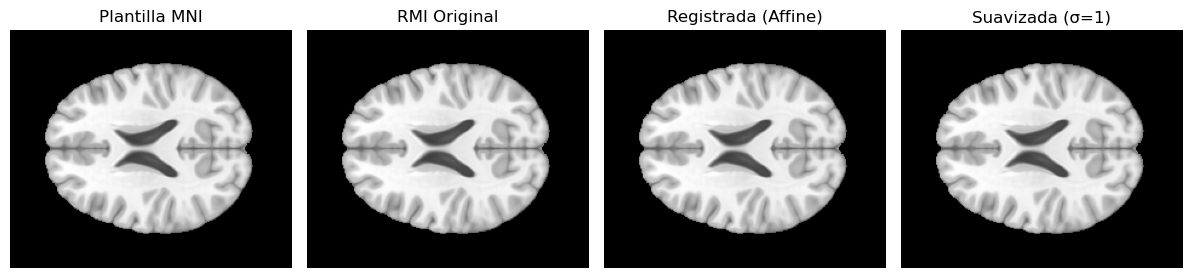

Figura guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\preproc_visualization.png
Imagen procesada guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\sub-1003\ses-wave1\anat\sub-1003_ses-wave1_acq-FLAIR_run-1_T2w_preproc.nii.gz
1 - C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-1003\ses-wave1\anat\sub-1003_ses-wave1_acq-MPRAGE_run-1_T1w.nii.gz
C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz


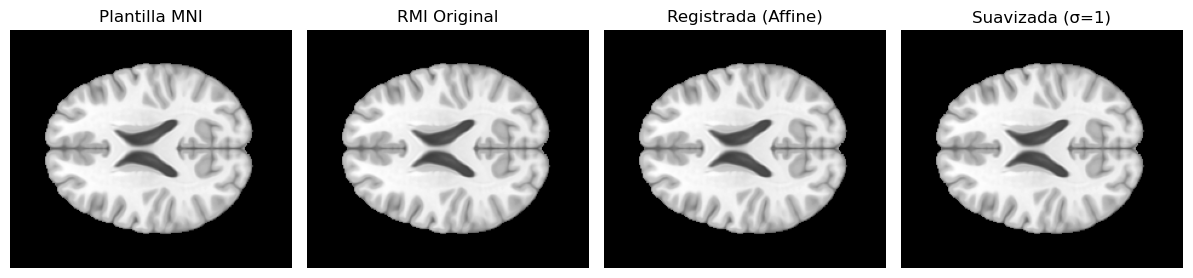

Figura guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\preproc_visualization.png
Imagen procesada guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\sub-1003\ses-wave1\anat\sub-1003_ses-wave1_acq-MPRAGE_run-1_T1w_preproc.nii.gz
2 - C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-1003\ses-wave2\anat\sub-1003_ses-wave2_acq-FLAIR_run-1_T2w.nii.gz
C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz


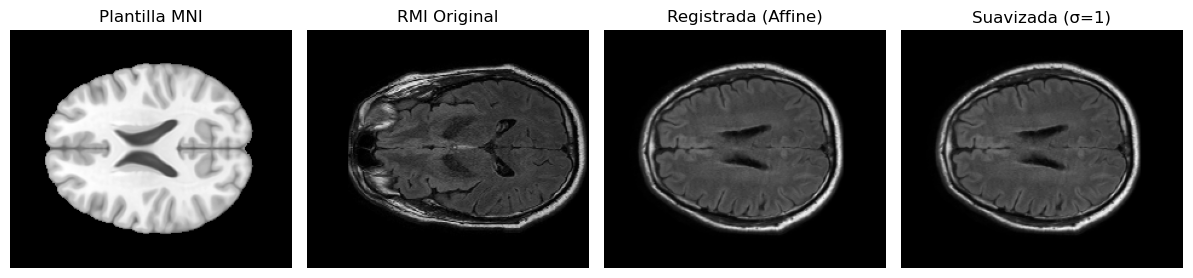

Figura guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\preproc_visualization.png
Imagen procesada guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\sub-1003\ses-wave2\anat\sub-1003_ses-wave2_acq-FLAIR_run-1_T2w_preproc.nii.gz
3 - C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-1003\ses-wave2\anat\sub-1003_ses-wave2_acq-MPRAGE_run-1_T1w.nii.gz
C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz


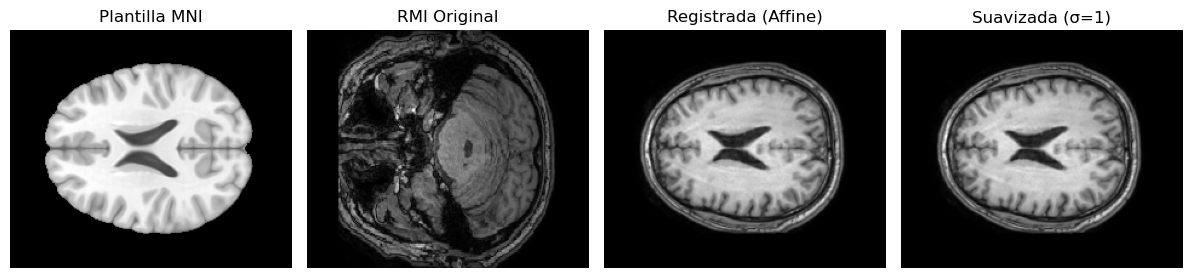

Figura guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\preproc_visualization.png
Imagen procesada guardada en: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS\sub-1003\ses-wave2\anat\sub-1003_ses-wave2_acq-MPRAGE_run-1_T1w_preproc.nii.gz
4 - C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-1003\ses-wave3\anat\sub-1003_ses-wave3_acq-FLAIR_run-1_T2w.nii.gz
C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-183\ses-wave1\anat\sub-183_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz


KeyboardInterrupt: 

In [29]:
#print(len(nii_paths_anat))
#path_processed = r"V:\\Datasets\\Dallas\\processed"
path_processed = r'C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA_TRANSFORMADAS'
print(mni_path)
for ix, (rmi_path) in enumerate(nii_paths):
    print(ix, '-', rmi_path)
    pipeline_preprocess2(rmi_path,  mni_path, dir_output = path_processed , debug = True)
    #if ix >= 3: break

